# GP_Predict Algorithm for Repeated Auctions

## Imports

In [8]:
# ! pip install cvxpy

In [9]:
import numpy as np
import cvxpy as cp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle
import re

## Bidders

In [10]:
# function to normalize payoffs in [0,1]

def normalize_util(payoffs, min_payoff, max_payoff):
    if min_payoff == max_payoff:
        return payoffs
    payoff_range = max_payoff - min_payoff
    payoffs = np.maximum(payoffs, min_payoff)
    payoffs = np.minimum(payoffs, max_payoff)
    payoffs_scaled = (payoffs - min_payoff) / payoff_range
    return payoffs_scaled


normalize = np.vectorize(normalize_util)

In [11]:
# parent class of bidders

class Bidder:
    def __init__(self, c_limit, d_limit, K, has_seed=False):
        self.K = K
        c_list = c_limit * np.random.sample(size=K)
        d_list = d_limit * np.random.sample(size=K)
        self.action_set = list(zip(c_list, d_list))
        # cost is a proper multiple of average bid function which is less than all of bid functions
        ratio_c = (c_list.min() / (2 * np.mean(c_list)))
        ratio_d = (d_list.min() / (2 * np.mean(d_list)))
        cost_ratio = min(ratio_c, ratio_d)
        self.cost = (np.mean(c_list) * cost_ratio, np.mean(d_list) * cost_ratio)
        self.weights = np.ones(K)
        self.history_payoff_profile = []
        self.history_action = []
        self.history_payoff = []
        self.cum_each_action = [0] * K
        self.played_action = None
        # to be able to reproduce exact same behavior
        self.has_seed = has_seed
        if self.has_seed:
            self.seed = np.random.randint(1, 10000)
            self.random_state = np.random.RandomState(seed=self.seed)

    # To clear stored data
    def restart(self):
        self.weights = np.ones(self.K)
        self.history_payoff_profile = []
        self.history_action = []
        self.history_payoff = []
        self.cum_each_action = [0] * self.K
        self.played_action = None
        if self.has_seed:
            self.random_state = np.random.RandomState(seed=self.seed)

    # choose action according to weights
    def choose_action(self):
        mixed_strategies = self.weights / np.sum(self.weights)
        if self.has_seed:
            choice = self.random_state.choice(len(self.action_set), p=mixed_strategies)
        else:
            choice = np.random.choice(len(self.action_set), p=mixed_strategies)
        return self.action_set[choice], choice

In [12]:
# Player using Hedge algorithm (Freund and Schapire. 1997)

class Hedge_bidder(Bidder):
    def __init__(self, c_limit, d_limit, K, max_payoff, T, has_seed=False):
        super().__init__(c_limit, d_limit, K, has_seed)
        self.type = 'Hedge'
        self.T = T
        self.learning_rate = np.sqrt(8 * np.log(self.K) / self.T)
        self.max_payoff = max_payoff

    def update_weights(self, payoffs):
        payoffs = normalize(payoffs, 0, self.max_payoff)
        losses = np.ones(self.K) - np.array(payoffs)
        self.weights = np.multiply(self.weights, np.exp(np.multiply(self.learning_rate, -losses)))
        self.weights = self.weights / np.sum(self.weights)

In [13]:
# Player choosing actions uniformly random each time

class random_bidder(Bidder):
    def __init__(self, c_limit, d_limit, K, has_seed=False):
        super().__init__(c_limit, d_limit, K, has_seed)
        self.type = 'random'

In [14]:
# Player using EXP3.P algorithm (Auer et al. 2002) with params according to Theorem 3.2 of 
# [Regret Analysis of Stochastic and Nonstochastic Multi-armed Bandit Problems, S. Bubeck, N. Cesa-Bianchi, 2012]

class EXP3_bidder(Bidder):
    def __init__(self, c_limit, d_limit, K, max_payoff, T, has_seed=False):
        super().__init__(c_limit, d_limit, K, has_seed)
        self.type = 'EXP3'
        self.rewards_est = np.zeros(K)
        self.T = T
        self.max_payoff = max_payoff

        delta = 0.01
        self.beta = np.sqrt(np.log(self.K * (1 / delta)) / (self.T * self.K))
        self.gamma = 1.05 * np.sqrt(np.log(self.K) * self.K / self.T)
        self.learning_rate = 0.95 * np.sqrt(np.log(self.K) / (self.T * self.K))
        assert 0 < self.beta < 1 and 0 < self.gamma < 1

    def update_weights(self, played_a, payoff):
        prob = self.weights[played_a] / np.sum(self.weights)
        payoff = normalize(payoff, 0, self.max_payoff)

        self.rewards_est = self.rewards_est + self.beta * np.divide(np.ones(self.K),
                                                                    self.weights / np.sum(self.weights))
        self.rewards_est[played_a] = self.rewards_est[played_a] + payoff / prob

        self.weights = np.exp(np.multiply(self.learning_rate, self.rewards_est))
        self.weights = self.weights / np.sum(self.weights)
        self.weights = (1 - self.gamma) * self.weights + self.gamma / self.K * np.ones(self.K)

In [15]:
# Player using GP_Predict Algorithm proposed

class GPMW_bidder(Hedge_bidder):
    def __init__(self, c_limit, d_limit, K, max_payoff, T, beta, has_seed=False):
        super().__init__(c_limit, d_limit, K, max_payoff, T, has_seed)
        self.type = 'GPMW'
        self.sigma = 0.001
        self.gpr = GaussianProcessRegressor(kernel=RBF(), alpha=self.sigma ** 2)
        self.gpr.optimizer = None
        self.input_history = []
        self.beta = beta
        self.max_payoff = max_payoff

    def restart(self):
        self.input_history = []
        super().restart()

    def update_weights(self, alloc_profile, marginal_price):
        self.input_history.append(list(alloc_profile) + [marginal_price, self.played_action[0], self.played_action[1]])
        self.gpr.fit(np.array(self.input_history), np.array(self.history_payoff))

        # all the input profiles that their payoffs need to be predicted
        input_predict = []
        for i in range(self.K):
            input_predict.append(list(alloc_profile) + [marginal_price, self.action_set[i][0], self.action_set[i][1]])
        mean, std = self.gpr.predict(input_predict, return_std=True)
        payoffs = mean + self.beta * std
        super().update_weights(payoffs)

## Functions to run the auction

In [16]:
# a class to store auction data

class auction_data:
    def __init__(self):
        self.bids = []
        self.allocations = []
        self.payments = []
        self.marginal_prices = []
        self.payoffs = []
        self.regrets = []

In [17]:
# estimates maximum payoff from results of a random play

def calc_max_payoff(Q, c_limit, d_limit, N, T, K):
    num_games = 10
    num_runs = 10
    game_data_profile = []
    for i in range(num_games):
        bidders = []
        for i in range(N):
            bidders.append(random_bidder(c_limit, d_limit, K))
        for run in range(num_runs):
            game_data_profile.append(run_auction(T, bidders, Q, regret_calc=False).payoffs)
    return np.max(np.array(game_data_profile))

In [18]:
# simulates the selection process in the auction

def optimize_alloc(bids, Q):
    C = np.array([param[0] for param in bids])
    C = np.diag(C)
    D = np.array([param[1] for param in bids])
    n = len(bids)
    A = np.ones(n).T
    G = - np.eye(n)
    h = np.zeros(n)

    # non-negativity doesn't strictly hold (small negative allocations might occur)
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(cp.quad_form(x, C) + D.T @ x),
                      [G @ x <= h, A @ x == Q])
    prob.solve()
    allocs = x.value
    # To fix very small values
    for i in range(len(allocs)):
        if allocs[i] < 10 ** (-5):
            allocs[i] = 0

    # only for quadratic case
    sample_winner = np.argmax(allocs)
    marginal_price = bids[sample_winner][0] * max(allocs) + bids[sample_winner][1]
    payments = marginal_price * allocs

    return allocs, marginal_price, payments

In [19]:
# runs a repeated auction

def run_auction(T, bidders, Q, regret_calc):
    for b in bidders:
        b.restart()
    game_data = auction_data()
    for t in range(T):
        bids = []
        for bidder in bidders:
            action, ind = bidder.choose_action()
            bidder.played_action = action
            bidder.history_action.append(ind)
            bids.append(action)
        x, marginal_price, payments = optimize_alloc(bids, Q)

        # calculates payoffs from payments
        payoff = []
        for i, bidder in enumerate(bidders):
            payoff_bidder = payments[i] - (bidder.cost[0] * x[i] + bidder.cost[1]) * x[i]
            payoff.append(payoff_bidder)
            bidder.history_payoff.append(payoff_bidder)
        game_data.payoffs.append(payoff)

        # calculates real regret for all bidders/ Hedge also needs this part for its update
        if regret_calc:
            regrets = []
            for i, bidder in enumerate(bidders):
                if i == len(bidders) - 1:
                    payoffs_each_action = []
                    for j, action in enumerate(bidder.action_set):
                        tmp_bids = bids.copy()
                        tmp_bids[i] = action
                        x_tmp, marginal_price_tmp, payments_tmp = optimize_alloc(tmp_bids, Q)
                        payoff_action = payments_tmp[i] - (bidder.cost[0] * x_tmp[i] + bidder.cost[1]) * x_tmp[i]
                        payoffs_each_action.append(payoff_action)
                        bidder.cum_each_action[j] += payoff_action
                    bidder.history_payoff_profile.append(np.array(payoffs_each_action))
                    regrets.append(
                        (max(bidder.cum_each_action) - sum([bidder.history_payoff[l] for l in range(t + 1)])))

            # update weights
            for i, bidder in enumerate(bidders):
                if bidder.type == 'Hedge':
                    bidder.update_weights(bidder.history_payoff_profile[t])
                if bidder.type == 'EXP3':
                    bidder.update_weights(bidder.history_action[t], bidder.history_payoff[t])
                if bidder.type == 'GPMW':
                    bidder.update_weights(x, marginal_price)
            game_data.regrets.append(regrets)

        # store data
        game_data.bids.append(bids)
        game_data.allocations.append(x)
        game_data.payments.append(payments)
        game_data.marginal_prices.append(marginal_price)

    return game_data

## Auxiliary functions

In [20]:
# extra function to train and test the fitness of GPMW prediction through random plays

def func_test(T_train, T_test):
    Q = 30
    N = 5
    c_limit = 100
    d_limit = 50
    K = 10
    bidders = []
    for i in range(N):
        bidders.append(random_bidder(c_limit, d_limit, K, Q))

    # train data
    game_data = run_auction(T_train, bidders, Q, False)
    # input data train
    bids_p1 = [bid[0] for bid in game_data.bids]
    input_data_p1 = []
    for i in range(T_train):
        input_data_p1.append(
            list(game_data.allocations[i]) + [game_data.marginal_prices[i], bids_p1[i][0], bids_p1[i][1]])
    # output data train
    payoff_p1 = [pay[0] for pay in game_data.payoffs]
    gpr = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10, alpha=0.001 ** 2)
    gpr.fit(np.array(input_data_p1), np.array(payoff_p1))
    # test data
    game_data = run_auction(T_test, bidders, Q, False)
    # input data test
    bids_p1 = [bid[0] for bid in game_data.bids]
    input_data_p1 = []
    for i in range(T_test):
        input_data_p1.append(
            list(game_data.allocations[i]) + [game_data.marginal_prices[i], bids_p1[i][0], bids_p1[i][1]])
    # output data test
    payoff_p1 = [pay[0] for pay in game_data.payoffs]
    mean, std = gpr.predict(input_data_p1, return_std=True)

    # best fit score = 1
    print(r2_score(payoff_p1, mean))
    # plot
    plt.plot(range(T_test), payoff_p1)
    p = plt.plot(range(T_test), mean)
    plt.fill_between(range(T_test), mean - std,
                     mean + std, alpha=0.1, color=p[0].get_color())
    plt.legend(['real payoff', 'predicted payoff'])
    plt.xlabel('Round')
    plt.ylabel('Payoff')
    plt.show()

## Simulation

In [21]:
# simulates #num_games different repeated auction #num_runs times for different bidder types and averages each result

def simulate(num_games, num_runs, T, N, K, file_name):
    Q = 30
    c_limit = 10
    d_limit = 5
    # max_payoff = calc_max_payoff(Q, c_limit, d_limit, N, T, K)
    # print(max_payoff)
    max_payoff = 500

    types = []
    types.append('Hedge')
    types.append('EXP3')
    types.append('Random')
    types.append('GPMW 0.1')
    # types.append('GPMW 0.01')
    # types.append('GPMW 1')
    # types.append('GPMW 10')
    game_data_profile = [[] for i in range(len(types))]
    for j in range(num_games):
        other_bidders = []
        for i in range(N - 1):
            other_bidders.append(random_bidder(c_limit, d_limit, K, has_seed=True))
            
        for type_idx, bidder_type in enumerate(types):
            if bidder_type == 'Hedge':
                bidders = other_bidders + [Hedge_bidder(c_limit, d_limit, K, max_payoff, T)]
            if bidder_type == 'EXP3':
                bidders = other_bidders + [EXP3_bidder(c_limit, d_limit, K, max_payoff, T)]
            match = re.match('(GPMW)\W?(\d+\.?\d*)?', bidder_type)
            if match:
                beta = match.groups()[1]
                if beta:
                    bidders = other_bidders + [GPMW_bidder(c_limit, d_limit, K, max_payoff, T, float(beta))]
            if bidder_type == 'Random':
                bidders = other_bidders + [random_bidder(c_limit, d_limit, K)]
                
            for run in tqdm(range(num_runs)):
                game_data_profile[type_idx].append(run_auction(T, bidders, Q, regret_calc=True))
                
    with open(f'{file_name}.pckl', 'wb') as file:
        pickle.dump(T, file)
        pickle.dump(c_limit, file)
        pickle.dump(d_limit, file)
        pickle.dump(Q, file)
        pickle.dump(types, file)
        pickle.dump(game_data_profile, file)

## Plotting

In [22]:
# plots the regrets

def plot_regret(file_name):
    with open(f'{file_name}.pckl', 'rb') as file:
        T = pickle.load(file)
        c_limit = pickle.load(file)
        d_limit = pickle.load(file)
        Q = pickle.load(file)
        types = pickle.load(file)
        game_data_profile = pickle.load(file)
    for i, typ in enumerate(types):
        data = np.array(
            [[game_data_profile[i][d].regrets[t][-1] for t in range(T)] for d in range(len(game_data_profile[i]))])
        mean = np.mean(data, 0)
        std = np.std(data, 0)
        p = plt.plot(range(T), mean, label=typ)
        color = p[0].get_color()
        plt.fill_between(range(T), mean - std,
                         mean + std, alpha=0.1,
                         color=color)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Regret')
    plt.show()

# Driver code

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


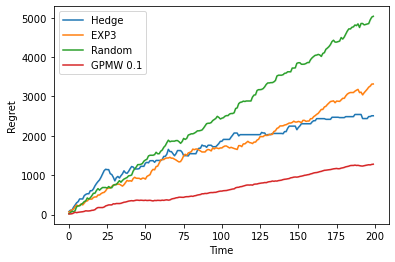

In [23]:
# func_test(30, 200)
# np.random.seed(12)
simulate(num_games=1, num_runs=1, T=200, N=6, K=5, file_name='res')
plot_regret('res')